In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/pd_speech_features.csv')

In [ ]:
df.shape

(756, 755)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [ ]:
df.describe()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,...,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,125.500000,0.515873,0.746284,0.700414,0.489058,323.972222,322.678571,0.006360,0.000383,0.002324,...,26.237251,22.840337,18.587888,13.872018,12.218953,12.375335,14.799230,14.751559,31.481110,0.746032
std,72.793721,0.500079,0.169294,0.069718,0.137442,99.219059,99.402499,0.001826,0.000728,0.002628,...,42.220693,32.626464,25.537464,20.046029,17.783642,16.341665,15.722502,14.432979,34.230991,0.435568
min,0.000000,0.000000,0.041551,0.543500,0.154300,2.000000,1.000000,0.002107,0.000011,0.000210,...,1.509800,1.531700,1.582900,1.747200,1.789500,1.628700,1.861700,1.955900,2.364000,0.000000
25%,62.750000,0.000000,0.762833,0.647053,0.386537,251.000000,250.000000,0.005003,0.000049,0.000970,...,2.408675,3.452800,3.354825,3.077450,2.937025,3.114375,3.665925,3.741275,3.948750,0.000000
50%,125.500000,1.000000,0.809655,0.700525,0.484355,317.000000,316.000000,0.006048,0.000077,0.001495,...,5.586300,7.062750,6.077400,4.770850,4.300450,4.741450,6.725700,7.334250,10.637250,1.000000
75%,188.250000,1.000000,0.834315,0.754985,0.586515,384.250000,383.250000,0.007528,0.000171,0.002520,...,28.958075,29.830850,21.944050,13.188000,10.876150,12.201325,21.922050,22.495175,61.125325,1.000000
max,251.000000,1.000000,0.907660,0.852640,0.871230,907.000000,905.000000,0.012966,0.003483,0.027750,...,239.788800,203.311300,121.542900,102.207000,85.571700,73.532200,62.007300,57.544300,156.423700,1.000000


In [ ]:
df = df.groupby('id').mean().reset_index()
df.drop('id', axis=1, inplace=True)


In [ ]:
columns = list(df.columns)
for col in columns:
    if col == 'class':
        continue

    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'class')):
            continue

        val = df[col].corr(df[col1])

        if val > 0.7:
            # If the correlation between the two
            # features is more than 0.7 remove
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)

    # After each iteration filter out the columns
    # which are not highly correlated features.
    df = df[filtered_columns]
df.shape

(252, 287)

In [ ]:
X = df.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape


(252, 31)

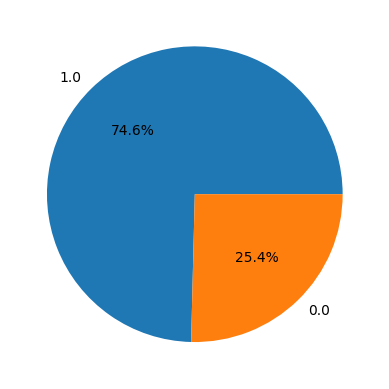

In [ ]:
x = df['class'].value_counts()
plt.pie(x.values,
		labels = x.index,
		autopct='%1.1f%%')
plt.show()

In [ ]:
features = df.drop('class', axis=1)
target = df['class']

X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target,
									test_size=0.2,
									random_state=10)
X_train.shape, X_val.shape


((201, 30), (51, 30))

In [ ]:
# As the data was highly imbalanced we will balance
# it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority',
						random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)
X.shape, Y.shape


((302, 30), (302,))

In [ ]:
from sklearn.metrics import roc_auc_score as ras
models = [LogisticRegression(), XGBClassifier()]

for i in range(len(models)):
	models[i].fit(X, Y)

	print(f'{models[i]} : ')

	train_preds = models[i].predict_proba(X)[:, 1]
	print('Training Accuracy : ', ras(Y, train_preds))

	val_preds = models[i].predict_proba(X_val)[:, 1]
	print('Validation Accuracy : ', ras(Y_val, val_preds))
	print()


LogisticRegression() : 
Training Accuracy :  0.8306214639708784
Validation Accuracy :  0.8127413127413127

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.9999999999999999
Validation Accuracy :  0.7857142857142857



In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

for i in range(len(models)):
    models[i].fit(X, Y)

    print(f'{models[i]} : ')

    train_preds = models[i].predict_proba(X)[:, 1]
    print('Training F1 Score : ', f1_score(Y, train_preds > 0.5))
    print('Training Recall : ', recall_score(Y, train_preds > 0.5))
    print('Training Precision : ', precision_score(Y, train_preds > 0.5))

    val_preds = models[i].predict_proba(X_val)[:, 1]
    print('Validation F1 Score : ', f1_score(Y_val, val_preds > 0.5))
    print('Validation Recall : ', recall_score(Y_val, val_preds > 0.5))
    print('Validation Precision : ', precision_score(Y_val, val_preds > 0.5))
    print()


LogisticRegression() : 
Training F1 Score :  0.7886435331230285
Training Recall :  0.8278145695364238
Training Precision :  0.7530120481927711
Validation F1 Score :  0.9210526315789475
Validation Recall :  0.9459459459459459
Validation Precision :  0.8974358974358975

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=Non

In [ ]:
from sklearn.metrics import confusion_matrix

for i in range(len(models)):
    models[i].fit(X, Y)

    print(f'{models[i]} : ')

    train_preds = models[i].predict(X)
    train_confusion_matrix = confusion_matrix(Y, train_preds)
    print('Training Confusion Matrix : ')
    print(train_confusion_matrix)

    val_preds = models[i].predict(X_val)
    val_confusion_matrix = confusion_matrix(Y_val, val_preds)
    print('Validation Confusion Matrix : ')
    print(val_confusion_matrix)
    print()


LogisticRegression() : 
Training Confusion Matrix : 
[[110  41]
 [ 26 125]]
Validation Confusion Matrix : 
[[10  4]
 [ 2 35]]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Confusion Matrix : 
[[151   0]
 [  0 151]]
Validation Confusion Matrix : 
[[ 6  8]
 [ 5 32]]



In [ ]:
from sklearn.metrics import classification_report

for i in range(len(models)):
    models[i].fit(X, Y)

    print(f'{models[i]} : ')

    train_preds = models[i].predict(X)
    print('Training Classification Report : ')
    print(classification_report(Y, train_preds))

    val_preds = models[i].predict(X_val)
    print('Validation Classification Report : ')
    print(classification_report(Y_val, val_preds))
    print()


LogisticRegression() : 
Training Classification Report : 
              precision    recall  f1-score   support

         0.0       0.81      0.73      0.77       151
         1.0       0.75      0.83      0.79       151

    accuracy                           0.78       302
   macro avg       0.78      0.78      0.78       302
weighted avg       0.78      0.78      0.78       302

Validation Classification Report : 
              precision    recall  f1-score   support

         0.0       0.83      0.71      0.77        14
         1.0       0.90      0.95      0.92        37

    accuracy                           0.88        51
   macro avg       0.87      0.83      0.85        51
weighted avg       0.88      0.88      0.88        51


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric

## Implementing Binary Bat Algorithm

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Define your classifier
classifier = XGBClassifier()

# Define your evaluation metric function
def evaluate_features(features, target, classifier):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred)

# Binary Bat Algorithm
def binary_bat_algorithm(features, target, classifier, n_iterations=100, n_bats=10, loudness=0.5, pulse_rate=0.5, alpha=0.9, gamma=0.9):
    n_features = features.shape[1]
    best_features = np.zeros(n_features)
    best_score = 0

    bats = np.random.randint(2, size=(n_bats, n_features))

    for _ in range(n_iterations):
        for i in range(n_bats):
            if np.random.rand() > pulse_rate:
                bat = bats[i]
                for j in range(n_features):
                    if np.random.rand() < loudness:
                        bat[j] = 1 - bat[j]

                score = evaluate_features(features[:, bat == 1], target, classifier)

                if (score > best_score) and (np.sum(bat) > 0):
                    best_score = score
                    best_features = bat

        pulse_rate *= alpha
        loudness *= gamma

    return best_features

# Run binary bat algorithm
selected_features = binary_bat_algorithm(features.values, target.values, classifier)

# Filter features based on selected indices
selected_indices = np.where(selected_features == 1)[0]
selected_feature_names = features.columns[selected_indices]

print("Selected Features:")
print(selected_feature_names)


Selected Features:
Index(['tqwt_kurtosisValue_dec_28', 'tqwt_kurtosisValue_dec_26',
       'tqwt_kurtosisValue_dec_25', 'tqwt_entropy_shannon_dec_17',
       'tqwt_entropy_shannon_dec_11', 'tqwt_energy_dec_28',
       'tqwt_energy_dec_26', 'tqwt_energy_dec_25', 'tqwt_energy_dec_12',
       'mean_MFCC_2nd_coef', 'IMF_SNR_SEO', 'DFA'],
      dtype='object')


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif


# Split data with selected features
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Feature Selection using SelectKBest with ANOVA F-value
k_best_selector = SelectKBest(score_func=f_classif, k='all')
X_train_selected = k_best_selector.fit_transform(X_train, y_train)
X_val_selected = k_best_selector.transform(X_val)

# Train logistic regression classifier
logistic_regression_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', LogisticRegression())
])

# Hyperparameter tuning using GridSearchCV
param_grid = {'classifier__C': [0.1, 1, 10, 100]}  # Example grid of hyperparameters
grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_logistic_regression_model = grid_search.best_estimator_

# Evaluate the model
train_accuracy1 = best_logistic_regression_model.score(X_train_selected, y_train)
val_accuracy1 = best_logistic_regression_model.score(X_val_selected, y_val)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)


Training Accuracy: 1.0
Validation Accuracy: 0.8235294117647058


In [ ]:
# Get predicted probabilities for the positive class
val_probs = best_logistic_regression_model.predict_proba(X_val_selected)[:, 1]

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_val, val_probs)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_val, val_probs)

print("ROC AUC Score:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

NameError: name 'best_logistic_regression_model' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Prepare the data with selected features
selected_features_data = features[selected_feature_names]

# Split the data into training and testing sets
X_train_selected, X_test_selected, y_train, y_test = train_test_split(selected_features_data, target, test_size=0.2, random_state=42)

# Initialize XGBoost classifier with some parameters
xgb_classifier = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=44)

# Train the classifier
xgb_classifier.fit(X_train_selected, y_train)

# Predict on training and testing data for accuracy
train_preds = xgb_classifier.predict(X_train_selected)
test_preds = xgb_classifier.predict(X_test_selected)

# Calculate accuracy for training and testing data
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)


Training Accuracy: 0.9950248756218906
Testing Accuracy: 0.7843137254901961


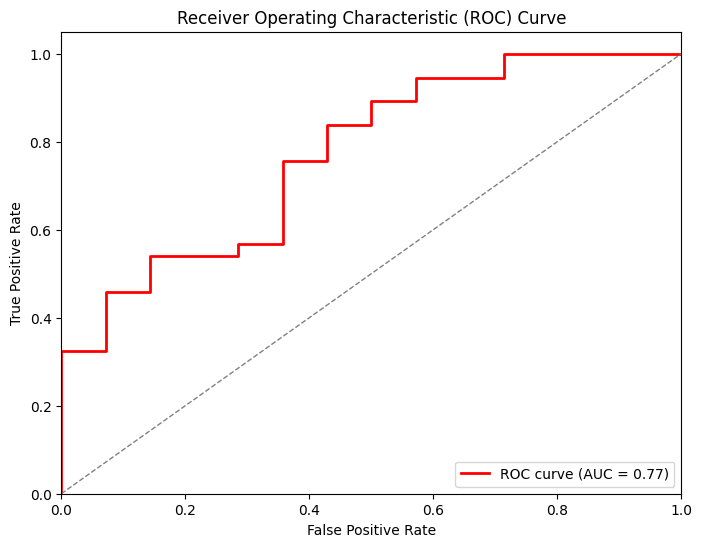

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
train_probs = xgb_classifier.predict_proba(X_train_selected)[:, 1]
test_probs = xgb_classifier.predict_proba(X_test_selected)[:, 1]

# Calculate ROC curve for training set
train_fpr, train_tpr, _ = roc_curve(y_train, train_probs)
train_roc_auc = auc(train_fpr, train_tpr)

# Calculate ROC curve for test set
test_fpr, test_tpr, _ = roc_curve(y_test, test_probs)
test_roc_auc = auc(test_fpr, test_tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(test_fpr, test_tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


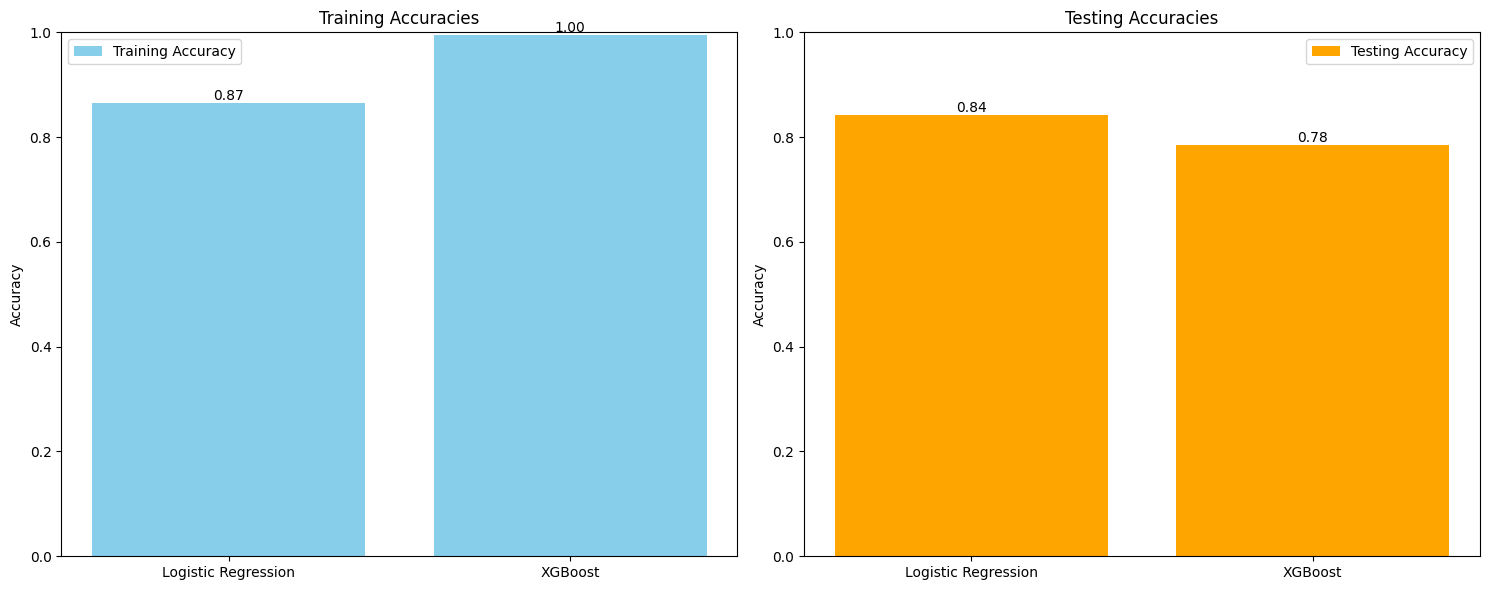

In [ ]:
import matplotlib.pyplot as plt

# Data
classifiers = ['Logistic Regression', 'XGBoost']
training_accuracies = [train_accuracy1, train_accuracy]
testing_accuracies = [val_accuracy1, test_accuracy]

# Plotting
plt.figure(figsize=(15, 6))

# Plotting the first subplot for training accuracy
plt.subplot(1, 2, 1)
plt.bar(classifiers, training_accuracies, color='skyblue', label='Training Accuracy')
for i in range(len(classifiers)):
    plt.text(i, training_accuracies[i], f"{training_accuracies[i]:.2f}", ha='center', va='bottom')
plt.title('Training Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# Plotting the second subplot for testing accuracy
plt.subplot(1, 2, 2)
plt.bar(classifiers, testing_accuracies, color='orange', label='Testing Accuracy')
for i in range(len(classifiers)):
    plt.text(i, testing_accuracies[i], f"{testing_accuracies[i]:.2f}", ha='center', va='bottom')
plt.title('Testing Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()


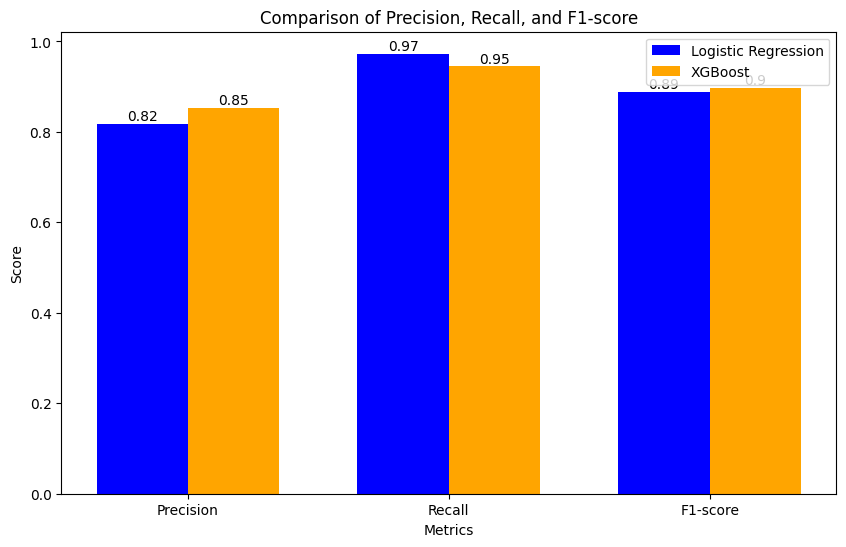

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Assuming you have defined variables for precision, recall, and F1-score for logistic regression and XGBoost

# Plotting precision, recall, and F1-score
labels_metrics = ['Precision', 'Recall', 'F1-score']
logistic_metrics = [logistic_precision, logistic_recall, logistic_f1]
xgb_metrics = [xgb_precision, xgb_recall, xgb_f1]

plt.figure(figsize=(10, 6))
x = range(len(labels_metrics))
width = 0.35
logistic_bars = plt.bar(x, logistic_metrics, width, label='Logistic Regression', color='blue')
xgb_bars = plt.bar([i + width for i in x], xgb_metrics, width, label='XGBoost', color='orange')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Comparison of Precision, Recall, and F1-score')
plt.xticks([i + width/2 for i in x], labels_metrics)
plt.legend()

# Add value annotations on top of each bar for logistic regression
for bar, score in zip(logistic_bars, logistic_metrics):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(score, 2),
             ha='center', va='bottom')

# Add value annotations on top of each bar for XGBoost
for bar, score in zip(xgb_bars, xgb_metrics):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(score, 2),
             ha='center', va='bottom')

plt.show()


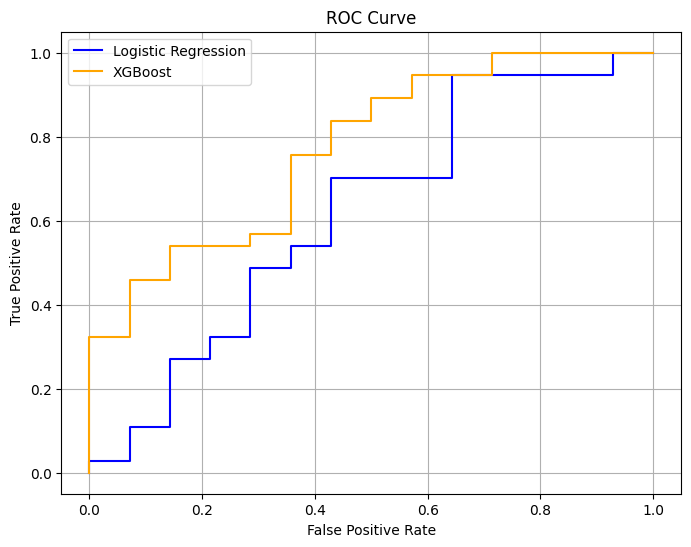

In [ ]:
# ROC curve
logistic_probs = best_logistic_classifier.predict_proba(X_val_scaled)[:, 1]
xgb_probs = xgb_classifier.predict_proba(X_test_selected)[:, 1]

fpr_logistic, tpr_logistic, _ = roc_curve(y_val, logistic_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, linestyle='-', label='Logistic Regression', color='blue')
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='XGBoost', color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

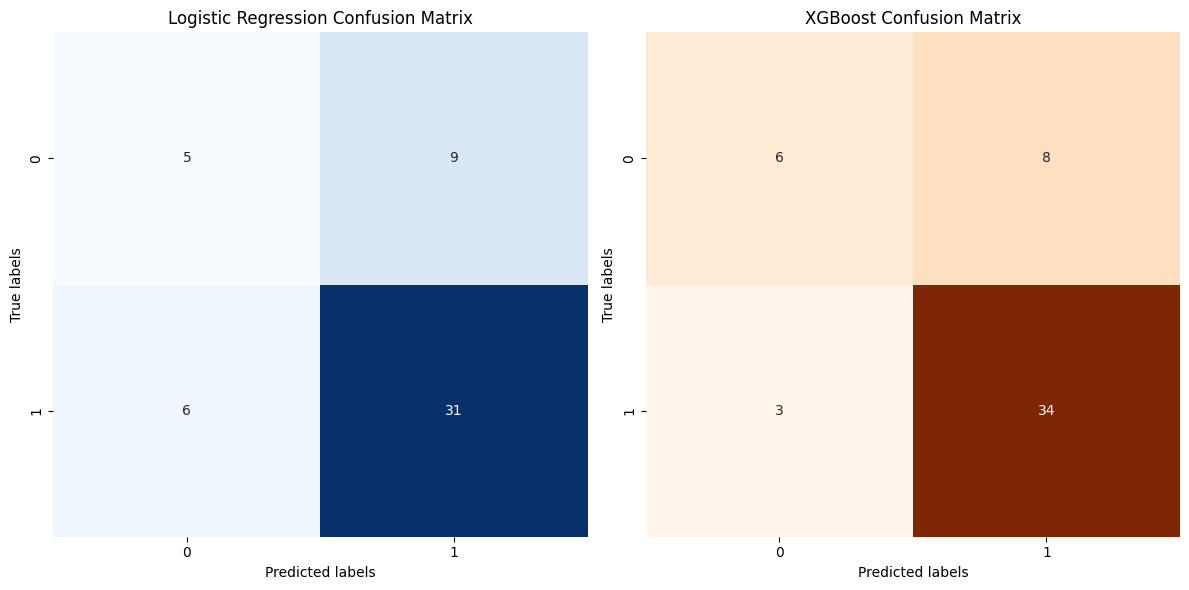

In [ ]:
# Confusion Matrix
logistic_conf_matrix = confusion_matrix(y_val, val_preds)
xgb_conf_matrix = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Logistic Regression Confusion Matrix')
sns.heatmap(logistic_conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(1, 2, 2)
plt.title('XGBoost Confusion Matrix')
sns.heatmap(xgb_conf_matrix, annot=True, cmap='Oranges', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.tight_layout()
plt.show()

# Implementing Genetic Algorithm

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import random

# Define parameters
POPULATION_SIZE = 20
NUM_GENERATIONS = 50
MUTATION_RATE = 0.1
NUM_SELECTED_FEATURES = 30

def fitness(chromosome, X_train, y_train, X_val, y_val):
    selected_features = [i for i, selected in enumerate(chromosome) if selected]
    if len(selected_features) == 0:
        return 0  # Avoid division by zero
    # Use selected features
    X_train_selected = X_train[:, selected_features]
    X_val_selected = X_val[:, selected_features]
    # Ensure NUM_SELECTED_FEATURES does not exceed the number of available features
    k = min(len(selected_features), NUM_SELECTED_FEATURES)
    # Train model
    model = Pipeline([
        ('scaler', MinMaxScaler()),
        ('feature_selection', SelectKBest(chi2, k=k)),
        ('classifier', LogisticRegression())
    ])
    model.fit(X_train_selected, y_train)
    # Evaluate model
    y_pred = model.predict_proba(X_val_selected)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    return auc


# Initialize population
population = np.random.randint(2, size=(POPULATION_SIZE, X_train.shape[1]))

# Split data
X_train, X_val, y_train, y_val = train_test_split(features.values, target.values, test_size=0.2, random_state=42)

# Genetic Algorithm
for generation in range(NUM_GENERATIONS):
    # Evaluate fitness
    fitness_scores = [fitness(chromosome, X_train, y_train, X_val, y_val) for chromosome in population]
    # Select parents
    selected_indices = np.random.choice(range(POPULATION_SIZE), size=2, replace=False, p=fitness_scores / np.sum(fitness_scores))
    parents = [population[i] for i in selected_indices]
    # Crossover
    crossover_point = random.randint(1, X_train.shape[1] - 1)
    offspring = np.concatenate([parents[0][:crossover_point], parents[1][crossover_point:]])
    # Mutation
    for i in range(len(offspring)):
        if random.random() < MUTATION_RATE:
            offspring[i] = 1 - offspring[i]  # Flip bit
    # Replace parent with offspring
    population[selected_indices[0]] = offspring

# Select the best chromosome
best_chromosome = population[np.argmax([fitness(chromosome, X_train, y_train, X_val, y_val) for chromosome in population])]
selected_features_indices = [i for i, selected in enumerate(best_chromosome) if selected]
selected_features = features.columns[selected_features_indices]
print("Selected Features:", selected_features)


Selected Features: Index(['tqwt_kurtosisValue_dec_34', 'tqwt_kurtosisValue_dec_28',
       'tqwt_kurtosisValue_dec_25', 'tqwt_TKEO_mean_dec_32',
       'tqwt_entropy_log_dec_26', 'tqwt_entropy_shannon_dec_17',
       'tqwt_entropy_shannon_dec_11', 'tqwt_energy_dec_33',
       'tqwt_energy_dec_28', 'tqwt_energy_dec_26', 'tqwt_energy_dec_25',
       'tqwt_energy_dec_16', 'tqwt_energy_dec_14', 'std_MFCC_8th_coef',
       'IMF_SNR_SEO', 'VFER_mean', 'DFA'],
      dtype='object')


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Split data with selected features
X_selected = features[selected_features]
X_train_selected, X_val_selected, y_train, y_val = train_test_split(X_selected, target, test_size=0.2, random_state=42)

# Train logistic regression classifier
logistic_regression_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', LogisticRegression())
])

logistic_regression_model.fit(X_train_selected, y_train)

# Evaluate the model
train_accuracy1 = logistic_regression_model.score(X_train_selected, y_train)
val_accuracy1 = logistic_regression_model.score(X_val_selected, y_val)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)


Training Accuracy: 0.9950248756218906
Validation Accuracy: 0.8235294117647058


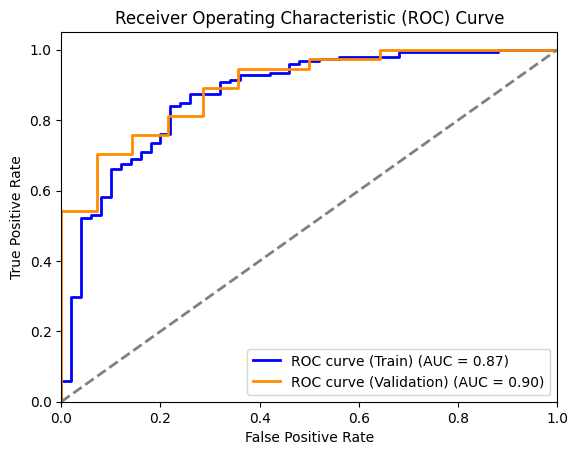

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_train_prob = logistic_regression_model.predict_proba(X_train_selected)[:, 1]
y_val_prob = logistic_regression_model.predict_proba(X_val_selected)[:, 1]

# Calculate ROC curve for training set
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate ROC curve for validation set
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='blue', lw=lw, label='ROC curve (Train) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_val, tpr_val, color='darkorange', lw=lw, label='ROC curve (Validation) (AUC = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Prepare the data with selected features
selected_features_data = features[selected_features]

# Split the data into training and testing sets
X_train_selected, X_test_selected, y_train, y_test = train_test_split(selected_features_data, target, test_size=0.2, random_state=42)

# Initialize XGBoost classifier with some parameters
xgb_classifier = XGBClassifier(n_estimators=110, max_depth=2, learning_rate=0.3, random_state=22)

# Train the classifier
xgb_classifier.fit(X_train_selected, y_train)

# Predict on training and testing data for accuracy
train_preds = xgb_classifier.predict(X_train_selected)
test_preds = xgb_classifier.predict(X_test_selected)

# Calculate accuracy for training and testing data
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)


Training Accuracy: 1.0
Testing Accuracy: 0.8627450980392157


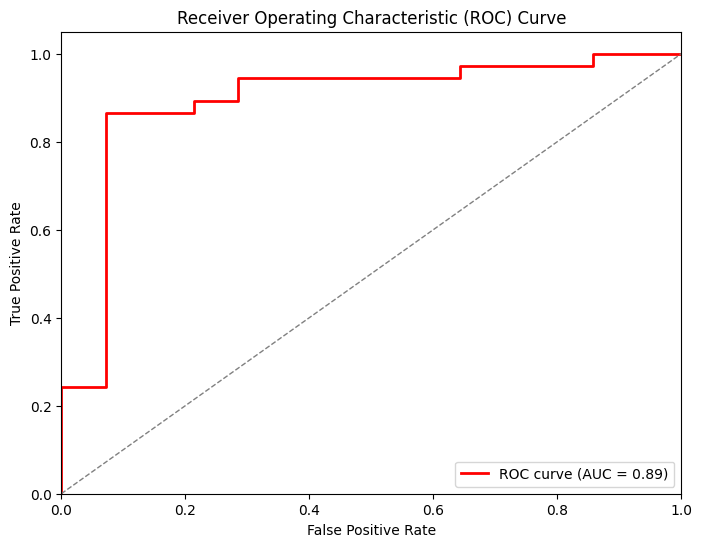

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
train_probs = xgb_classifier.predict_proba(X_train_selected)[:, 1]
test_probs = xgb_classifier.predict_proba(X_test_selected)[:, 1]

# Calculate ROC curve for training set
train_fpr, train_tpr, _ = roc_curve(y_train, train_probs)
train_roc_auc = auc(train_fpr, train_tpr)

# Calculate ROC curve for test set
test_fpr, test_tpr, _ = roc_curve(y_test, test_probs)
test_roc_auc = auc(test_fpr, test_tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(test_fpr, test_tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


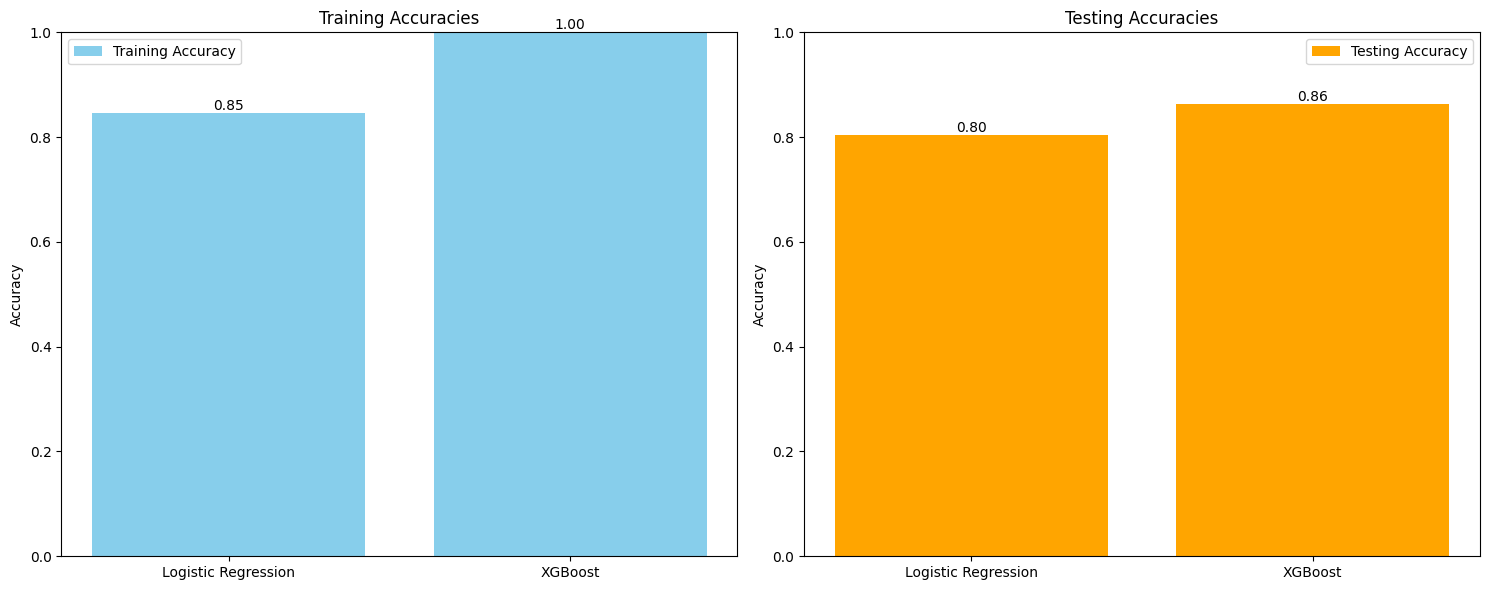

In [ ]:
import matplotlib.pyplot as plt

# Data
classifiers = ['Logistic Regression', 'XGBoost']
training_accuracies = [train_accuracy1, train_accuracy]
testing_accuracies = [val_accuracy1, test_accuracy]

# Plotting
plt.figure(figsize=(15, 6))

# Plotting the first subplot for training accuracy
plt.subplot(1, 2, 1)
plt.bar(classifiers, training_accuracies, color='skyblue', label='Training Accuracy')
for i in range(len(classifiers)):
    plt.text(i, training_accuracies[i], f"{training_accuracies[i]:.2f}", ha='center', va='bottom')
plt.title('Training Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# Plotting the second subplot for testing accuracy
plt.subplot(1, 2, 2)
plt.bar(classifiers, testing_accuracies, color='orange', label='Testing Accuracy')
for i in range(len(classifiers)):
    plt.text(i, testing_accuracies[i], f"{testing_accuracies[i]:.2f}", ha='center', va='bottom')
plt.title('Testing Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Logistic Regression
logistic_regression_model.fit(X_train_selected, y_train)
y_pred_lr = logistic_regression_model.predict(X_val_selected)

# XGBoost
xgb_classifier.fit(X_train_selected, y_train)
y_pred_xgb = xgb_classifier.predict(X_test_selected)

# Classification Report
print("Logistic Regression Classification Report:")
print(classification_report(y_val, y_pred_lr))

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.36      0.50        14
         1.0       0.80      0.97      0.88        37

    accuracy                           0.80        51
   macro avg       0.82      0.67      0.69        51
weighted avg       0.81      0.80      0.77        51


XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.64      0.72        14
         1.0       0.88      0.95      0.91        37

    accuracy                           0.86        51
   macro avg       0.85      0.79      0.81        51
weighted avg       0.86      0.86      0.86        51



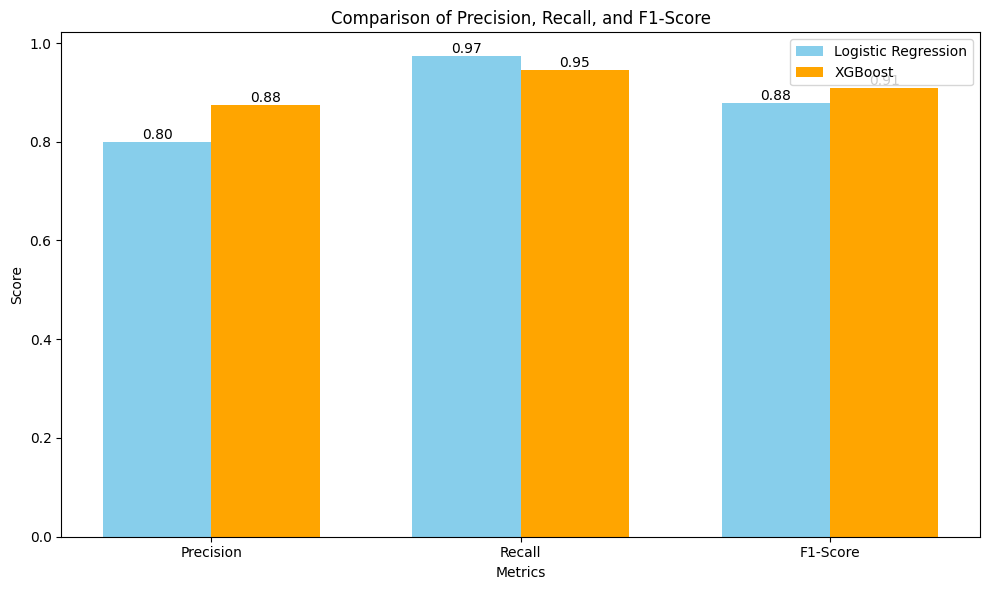

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score for Logistic Regression
precision_lr, recall_lr, f1_score_lr, _ = precision_recall_fscore_support(y_val, y_pred_lr, average='binary')

# Calculate precision, recall, and F1-score for XGBoost
precision_xgb, recall_xgb, f1_score_xgb, _ = precision_recall_fscore_support(y_test, y_pred_xgb, average='binary')

# Data
metrics = ['Precision', 'Recall', 'F1-Score']
lr_scores = [precision_lr, recall_lr, f1_score_lr]
xgb_scores = [precision_xgb, recall_xgb, f1_score_xgb]

x = range(len(metrics))

# Plotting
plt.figure(figsize=(10, 6))

bar_width = 0.35
plt.bar(x, lr_scores, width=bar_width, label='Logistic Regression', color='skyblue')
plt.bar([i + bar_width for i in x], xgb_scores, width=bar_width, label='XGBoost', color='orange')

# Adding the metric values on top of the bars
for i in range(len(metrics)):
    plt.text(i, lr_scores[i], f"{lr_scores[i]:.2f}", ha='center', va='bottom')
    plt.text(i + bar_width, xgb_scores[i], f"{xgb_scores[i]:.2f}", ha='center', va='bottom')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Comparison of Precision, Recall, and F1-Score')
plt.xticks([i + bar_width / 2 for i in x], metrics)
plt.legend()
plt.tight_layout()
plt.show()


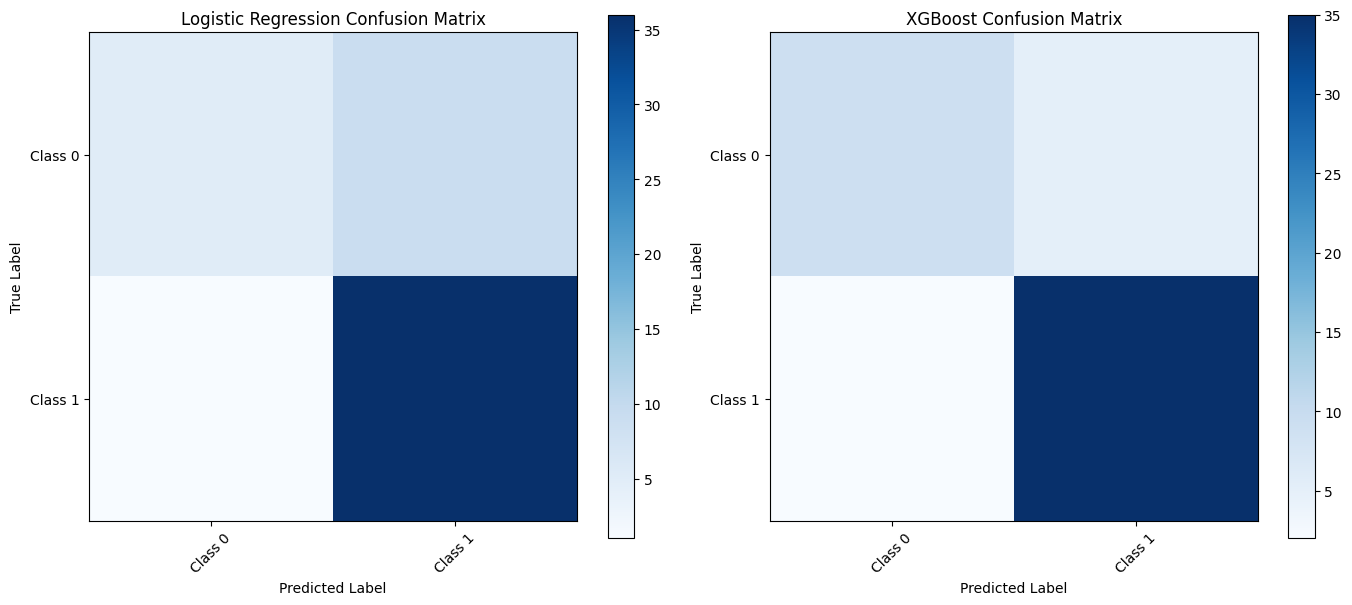

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(matrix_list, titles):
    num_matrices = len(matrix_list)
    plt.figure(figsize=(14, 6))

    for i, (matrix, title) in enumerate(zip(matrix_list, titles), 1):
        plt.subplot(1, num_matrices, i)
        plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(matrix.shape[0])
        plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
        plt.yticks(tick_marks, ['Class 0', 'Class 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()

# Assuming y_val, y_pred_lr, y_test, and y_pred_xgb are defined
cm_lr = confusion_matrix(y_val, y_pred_lr)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plot_confusion_matrices([cm_lr, cm_xgb], ["Logistic Regression Confusion Matrix", "XGBoost Confusion Matrix"])


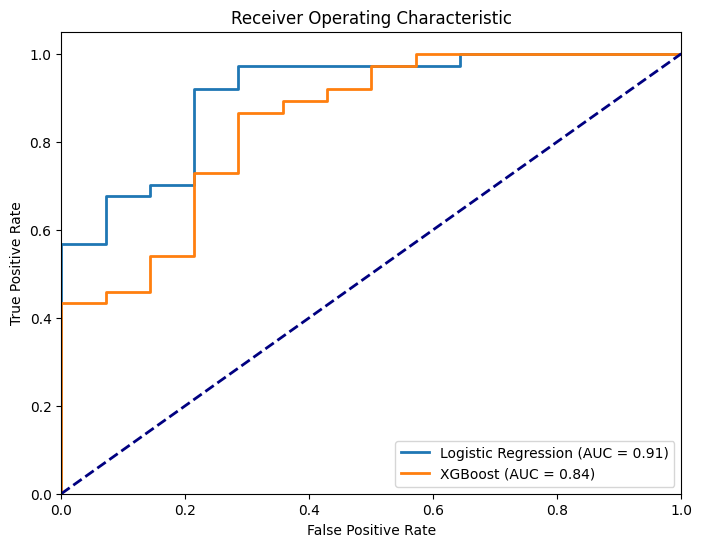

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true_list, y_pred_proba_list, titles):
    plt.figure(figsize=(8, 6))

    for y_true, y_pred_proba, title in zip(y_true_list, y_pred_proba_list, titles):
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.2f)' % (title, roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Assuming y_val, y_pred_lr_proba, y_test, and y_pred_xgb_proba are defined
plot_roc_curves([y_val, y_test], [y_pred_lr_proba, y_pred_xgb_proba], ["Logistic Regression", "XGBoost"])
